In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

class State:
    """ a container to hold a single star's position """

    def __init__(self, x, y, u, v):

        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        return State(self.x + other.x, self.y + other.y,
                     self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        return State(self.x - other.x, self.y - other.y,
                     self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        return State(other * self.x, other * self.y,
                     other * self.u, other * self.v)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        return f"{self.x:10.6f} {self.y:10.6f}{self.u:10.6f} {self.v:10.6f}"


class ThreeBody:
    """ model the gravitational interaction of three stars """

    def __init__(self, d0,d1,d2, SMALL=1.e-30):
        """ pos is a tuple of x-y coords of the stars """

        self.G = 1  # dimensionless units

        star0 = State(d0['p0'][0], d0['p0'][1], d0['u0'][0], d0['u0'][1])
        star1 = State(d1['p0'][0], d1['p0'][1], d1['u0'][0], d1['u0'][1])
        star2 = State(d2['p0'][0], d2['p0'][1], d2['u0'][0], d2['u0'][1])

        # this history will be stored in a list of tuples, such that
        # stars[n][istar] is star istar and timestep n

        self.stars = [(star0, star1, star2)]

        self.M = np.array([d0['m'], d1['m'], d2['m']])

        self.SMALL = SMALL

        self.time = [0.0]

    def npts(self):
        """ return the number of integration points """
        return len(self.time)

    def center_of_mass(self, n):
        """return the center of mass of the system at time n"""

        Mtot = np.sum(self.M)

        x_cm = 0.0
        y_cm = 0.0


        for mass, star in zip(self.M, self.stars[n]):
            x_cm += mass * star.x
            y_cm += mass * star.y


        x_cm /= Mtot
        y_cm /= Mtot


        return x_cm, y_cm

    def energy(self, n):
        """return the energy of the system at time n """

        # kinetic energy
        KE = [0.5 * self.M[i] * (self.stars[n][i].u**2 +
                                 self.stars[n][i].v**2 )
              for i in range(len(self.M))]

        # potential energy -- we need all pairs, but order doesn't matter

        PE = [-self.G * self.M[i] * self.M[j] /
              np.sqrt((self.stars[n][i].x - self.stars[n][j].x)**2 +
                      (self.stars[n][i].y - self.stars[n][j].y)**2 )
              for i in range(len(self.M)) for j in range(len(self.M)) if i > j]

        return sum(KE) + sum(PE)

    def rhs(self, star_states):
        """ here, star states is (State, State, ...) """

        ydots = []

        for istar in range(len(self.M)):

            # compute the space derivatives

            dxdt = star_states[istar].u
            dydt = star_states[istar].v

            # compute the velocity derivatives
            dudt = 0.0
            dvdt = 0.0

            for jstar in range(len(self.M)):
                if istar == jstar:
                    continue
                else:
                    dx = star_states[jstar].x - star_states[istar].x
                    dy = star_states[jstar].y - star_states[istar].y

                    r = np.sqrt(dx**2 + dy**2 ) + self.SMALL

                    dudt += self.G * self.M[jstar] * dx / r**3
                    dvdt += self.G * self.M[jstar] * dy / r**3

            ydots.append(State(dxdt, dydt, dudt, dvdt))

        return ydots


    def single_step(self, state_old, dt):
        """ take a single RK-4 timestep from t to t+dt for the system
        ydot = rhs """

        ydot1 = self.rhs(state_old)

        state_temp = [state_old[istar] + 0.5 * dt * ydot1[istar]
                      for istar in range(len(self.M))]
        ydot2 = self.rhs(state_temp)

        state_temp = [state_old[istar] + 0.5 * dt * ydot2[istar]
                      for istar in range(len(self.M))]
        ydot3 = self.rhs(state_temp)

        state_temp = [state_old[istar] + dt * ydot3[istar]
                      for istar in range(len(self.M))]
        ydot4 = self.rhs(state_temp)

        state_new = [state_old[istar] + (dt/6.0) * (ydot1[istar] + 2.0*ydot2[istar] +
                                                    2.0*ydot3[istar] + ydot4[istar])
                     for istar in range(len(self.M))]

        return state_new

    def integrate(self, dt, err, tmax):
        """ integrate the equations of motion using 4th order R-K
            method with an adaptive stepsize, to try to achieve the
            relative error err.  dt here is the initial timestep

            if err < 0, then we don't do adaptive stepping, but rather
            we always walk at the input dt
            """

        # safety parameters
        S1 = 0.9
        S2 = 4.0

        # initial conditions
        t = 0.0

        # start with the old timestep
        dt_new = dt

        n_reset = 0

        while t < tmax:

            state_old = self.stars[-1]

            # adaptive stepping iteration loop -- keep trying to take
            # a step until we achieve our desired error
            rel_error = 1.e10

            n_try = 0
            while rel_error > err:
                dt = dt_new
                if t + dt > tmax:
                    dt = tmax-t

                # take 2 half steps
                state_tmp = self.single_step(state_old, 0.5*dt)
                state_new = self.single_step(state_tmp, 0.5*dt)

                # now take just a single step to cover dt
                state_single = self.single_step(state_old, dt)

                # state_new should be more accurate than state_single,
                # since it used smaller steps.

                # estimate the relative error now
                pos_err = max([max(abs((state_new[istar].x - state_single[istar].x) / state_single[istar].x),
                                   abs((state_new[istar].y - state_single[istar].y) / state_single[istar].y))
                               for istar in range(len(self.M))])

                vel_err = max([max((abs(state_new[istar].u - state_single[istar].u) / state_single[istar].u),
                                   (abs(state_new[istar].v - state_single[istar].v) / state_single[istar].v))
                               for istar in range(len(self.M))])

                rel_error = max(pos_err, vel_err)

                # adaptive timestep algorithm from Garcia (Eqs. 3.30
                # and 3.31)
                dt_est = dt * abs(err / rel_error)**0.2
                dt_new = min(max(S1*dt_est, dt/S2), S2*dt)

                n_try += 1

            if n_try > 1:
                # n_try = 1 if we took only a single try at the step
                n_reset += (n_try-1)

            # successful step
            t += dt

            # set for the next step
            self.time.append(t)
            self.stars.append(state_new)

    

# Data Project 1: Many Body Problem
In this data project, we will be exploring the long-term dynamical stability of satellites in a three-body system, with the *Jupiter trojans* as our test case. To do this, we will run some simple numerical simulations that evolve the positions and velocities of gravitationally interacting objects for three bodies orbiting in one plane (i.e. restricted to two dimensions). The code advances each particle according to its equation of motion, integrating it's future positions and velocities using a Runge-Kutta scheme.  


The code for setting up these simulations is in the above cell (run it once, but do not alter any of the code within that cell).   


The rest of the assignment has been scaffolded: there is existing code provided as an example and some functions have been pre-defined for your use with comments marking areas in which you should add your own inputs. Required regions for your input will have a ```#[*HERE*]``` comment.  You may need to write additional code or choose to modify the existing code (as long as the final result can be run only from what is contained in your submitted notebook)


## Part I: Modified Two-Body Problem



In [73]:
G = 1
Msun = 1

def p_to_cart(r,phi):
    return (r*np.cos(phi),r*np.sin(phi))

def p_to_cyl(x,y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return (r,phi)

def v_to_cart(vtot,phi):
    return (-vtot*np.sin(phi),vtot*np.cos(phi))

def p_rotate(p,dphi):
    x,y = p
    r,phi0 = p_to_cyl(x,y)
    return p_to_cart(r,phi0+dphi)


def set_v(p0,m0=1):
    x,y = p0
    r,phi = p_to_cyl(x,y)
    vtot = np.sqrt(m0/r)
    return v_to_cart(vtot,phi)

SMALL = 1E-32
p_s = (0,0)
v_s = (0,0)
p_j = (5.2,0)
v_j = set_v(p_j)


Sun = {'m':1,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':1e-3, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':SMALL, 'p0':p_j,'u0':v_j,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*100
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)

#position of the center of mass
x_cm = np.array([(tb.center_of_mass(n))[0] for n in np.arange(len(tb.time))])
y_cm = np.array([(tb.center_of_mass(n))[1] for n in np.arange(len(tb.time))])
time_orb = np.array(tb.time)/t_orb
bodies = [Sun,Jupiter,Third]

#assign values
for istar,body in zip(range(len(tb.M)),bodies):
    x = np.array([star[istar].x for star in tb.stars])
    y = np.array([star[istar].y for star in tb.stars])
    x = x 
    y = y 
    body['x'] = x
    body['y'] = y


Text(0.5, 1.0, 'Rotating Frame')

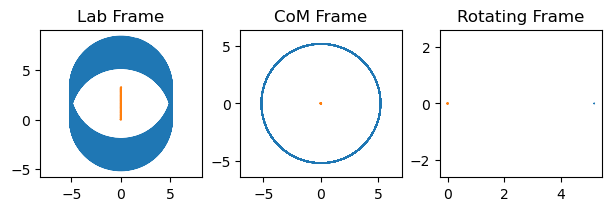

In [74]:
f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=100)
f.set_size_inches(6,2)

#Lab Frame
a1.plot(Jupiter['x'],Jupiter['y'],lw=1)
a1.plot(Sun['x'],Sun['y'])

#CoM Frame
Jupiter['x_cm'] = Jupiter['x'] - x_cm
Jupiter['y_cm'] = Jupiter['y'] - y_cm
Sun['x_cm'] = Sun['x'] - x_cm
Sun['y_cm'] = Sun['y'] - y_cm

a2.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1)
a2.plot(Sun['x_cm'],Sun['y_cm'])

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
a3.plot(*J_frame,lw=1)
a3.plot(*S_frame)

for a in (a1,a2,a3):
    a.set_xlim(-6,6)
    a.set_ylim(-6,6)
    a.axis('equal')

a1.set_title('Lab Frame')
a2.set_title('CoM Frame')
a3.set_title('Rotating Frame')


## Part II: Constrained Three-Body Problem
### a. Steady-State Libration

In [75]:
p_s = (0,0)
v_s = (0,0)
p_j = (5.2,0)
v_j = set_v(p_j)
p_3 = p_rotate((5.2,0),np.radians(40))
v_3 = set_v(p_3)

def calc_J(pi,pj,vi):
    xi = pi[0]
    yi = pi[1]
    xj = pj[0]
    yj = pj[1]
    dr = np.sqrt((xi-xj)**2 + (yi-yj)**2)
    return xi**2 + yi**2 + 2/(xi**2 + yi**2) + 2*1e-3/dr - vi[0]**2 - vi[1]**2

print(calc_J(p_3,p_j,(0,0)))

Sun = {'m':1,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':1e-3, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':1e-9, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*100
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)

#position of the center of mass
x_cm = np.array([(tb.center_of_mass(n))[0] for n in np.arange(len(tb.time))])
y_cm = np.array([(tb.center_of_mass(n))[1] for n in np.arange(len(tb.time))])
time_orb = np.array(tb.time)/t_orb
bodies = [Sun,Jupiter,Third]

#assign values
for istar,body in zip(range(len(tb.M)),bodies):
    x = np.array([star[istar].x for star in tb.stars])
    y = np.array([star[istar].y for star in tb.stars])
    x = x 
    y = y 
    body['x'] = x
    body['y'] = y

Jupiter['x_cm'] = Jupiter['x'] - x_cm
Jupiter['y_cm'] = Jupiter['y'] - y_cm
Sun['x_cm'] = Sun['x'] - x_cm
Sun['y_cm'] = Sun['y'] - y_cm
Third['x_cm'] = Third['x'] - x_cm
Third['y_cm'] = Third['y'] - y_cm

27.11452676711837


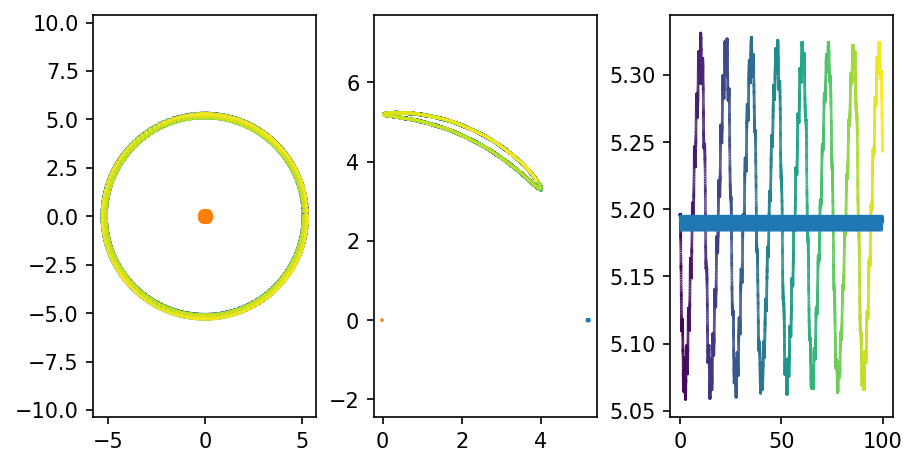

In [76]:
f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6,3)


# CoM Frame
a1.scatter(Jupiter['x_cm'],Jupiter['y_cm'],s=0.1)
a1.scatter(Sun['x_cm'],Sun['y_cm'])
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1)


# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.plot(*J_frame,lw=2)
a2.plot(*S_frame)
a2.scatter(*T_frame,c=time_orb,s=0.1)

a1.set_xlim(-6,6)
a1.set_ylim(-6,6)
a1.axis('equal')
a2.set_xlim(-6,6)
a2.set_ylim(-6,6)
a2.axis('equal')

# Libration as a function of time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj)
a3.scatter(time_orb, r3,c=time_orb,s=0.1)






### b. Horseshoe Orbit

In [77]:
p_s = (0,0)
v_s = (0,0)
p_j = (5.2,0)
v_j = set_v(p_j)
p_3 = p_rotate((5.13,0),np.radians(15))
v_3 = set_v(p_3)
v_3 += (0.0,0.0)
def calc_J(pi,pj,vi):
    xi = pi[0]
    yi = pi[1]
    xj = pj[0]
    yj = pj[1]
    dr = np.sqrt((xi-xj)**2 + (yi-yj)**2)
    return xi**2 + yi**2 + 2/(xi**2 + yi**2) + 2*1e-3/dr - vi[0]**2 - vi[1]**2

print(calc_J(p_3,p_j,(0.0,0.0)))

Sun = {'m':1,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':1e-3, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':1e-9, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*100
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)

#position of the center of mass
x_cm = np.array([(tb.center_of_mass(n))[0] for n in np.arange(len(tb.time))])
y_cm = np.array([(tb.center_of_mass(n))[1] for n in np.arange(len(tb.time))])
time_orb = np.array(tb.time)/t_orb
bodies = [Sun,Jupiter,Third]

#assign values
for istar,body in zip(range(len(tb.M)),bodies):
    x = np.array([star[istar].x for star in tb.stars])
    y = np.array([star[istar].y for star in tb.stars])
    x = x 
    y = y 
    body['x'] = x
    body['y'] = y

Jupiter['x_cm'] = Jupiter['x'] - x_cm
Jupiter['y_cm'] = Jupiter['y'] - y_cm
Sun['x_cm'] = Sun['x'] - x_cm
Sun['y_cm'] = Sun['y'] - y_cm
Third['x_cm'] = Third['x'] - x_cm
Third['y_cm'] = Third['y'] - y_cm

26.39437814221247


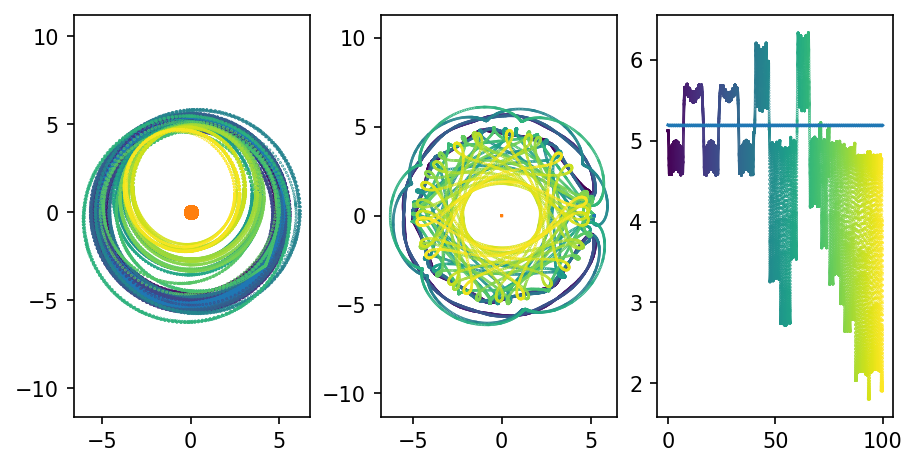

In [78]:
f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6,3)

# CoM Frame
a1.scatter(Jupiter['x_cm'],Jupiter['y_cm'])
a1.scatter(Sun['x_cm'],Sun['y_cm'])
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1)


# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.plot(*J_frame)
a2.plot(*S_frame)
a2.scatter(*T_frame,c=time_orb,s=0.1)

a1.set_xlim(-6,6)
a1.set_ylim(-6,6)
a1.axis('equal')
a2.set_xlim(-6,6)
a2.set_ylim(-6,6)
a2.axis('equal')

# Libration as a function of time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj)
a3.scatter(time_orb, r3,c=time_orb,s=0.1)




### c. Long-term Stability

In [79]:


SMALL = 1E-32
Sun = {'m':1,'p0':(0,0,0),'u0':(0,0,0)}
LJ = Lpt((5.2,0,0),-20)
Lj = Lpt((5.2,0,0),20)
Jupiter = {'m':1e-3, 'p0':LJ,'u0':vi_k(LJ)}
Third = {'m':1e-10, 'p0':Lj,'u0':vi_k(Lj,Ms=1.5)}
#Third = {'m':1e-12, 'p0':(5.05,0,1e-4),'u0':vi_k((5.05,0,1e-4))}




print(f"number of steps: {tb.npts()}")

def orbit(tb):
    fig,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True)
    fig.set_size_inches((9,3))
    markers = ['x','o',',']
    n_orb = np.array(tb.time)/t_orb
    n_max = int(np.amax(n_orb))
    cmap = mpl.colormaps['PuOr']
    cc = cmap(np.linspace(0, 1, n_max))
    ls = ['solid','solid','solid']
    
    phij = []
    for star,cm in zip(tb.stars,p_cm):
        xs = star[1].x
        ys = star[1].y
        phij = np.append(phij,np.degrees(phic((xs-cm[0],ys-cm[1]))))
    print(phij)
    n_vals = np.arange(0,n_max,1)
    orb_i=[0]
    for i in n_vals:
        ii = len(n_orb[n_orb<i])
        orb_i = np.append(orb_i,ii)
    
    for istar in range(len(tb.M)):
        x = np.array([star[istar].x for star in tb.stars])
        y = np.array([star[istar].y for star in tb.stars])
        x = x -p_cm[:,0]
        y = y - p_cm[:,1]
        for i in range(len(orb_i)-1):
            colors =  ['C1','maroon',cc[i]]
            ii = orb_i[i]
            iii = orb_i[i+1]
            xc = x[ii:iii]
            yc = y[ii:iii]
            a1.plot(xc,yc, alpha=1-i/n_max,color=colors[istar],ls=ls[istar],lw=1)
            xcg,ycg,zcg = Lpt((xc,yc),-phij[ii:iii])
            a3.plot(xcg,ycg, alpha=1-i/n_max,color=colors[istar],ls=ls[istar],lw=1)

        if istar > 0:
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan2(x,y)
            a2.plot(np.array(tb.time),r,color=colors[istar],alpha=0.5,ls=ls[istar],lw=0, marker=',')
            a2.scatter(0, [r[0]], marker="o",color=colors[istar])

    a1.set_xlim(-6,6)
    a1.set_ylim(-6,6)
    a3.set_xlim(-6,6)
    a3.set_ylim(-6,6)
    #ax[0].axis('equal')

    #ax[1].set_xlim

    fig.savefig("three_body.png")


orbit(tb)







NameError: name 'Lpt' is not defined

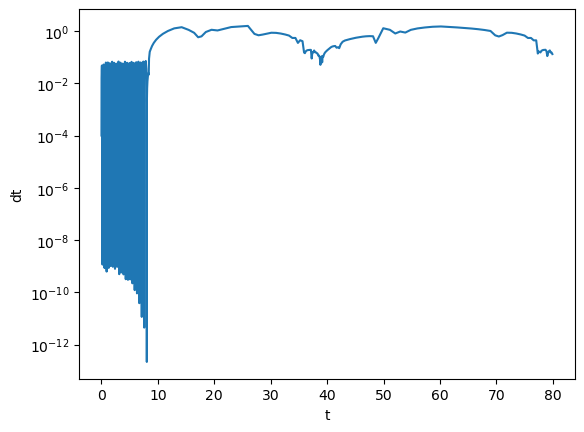

In [ ]:
# timestep plot

t = np.asarray(t)
dt = t[1:] - t[:-1]
ts = 0.5 * (t[1:] + t[:-1])

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(ts, dt)
ax.set_yscale("log")

ax.set_xlabel("t")
ax.set_ylabel("dt")

fig.savefig("three_body_dts.png")





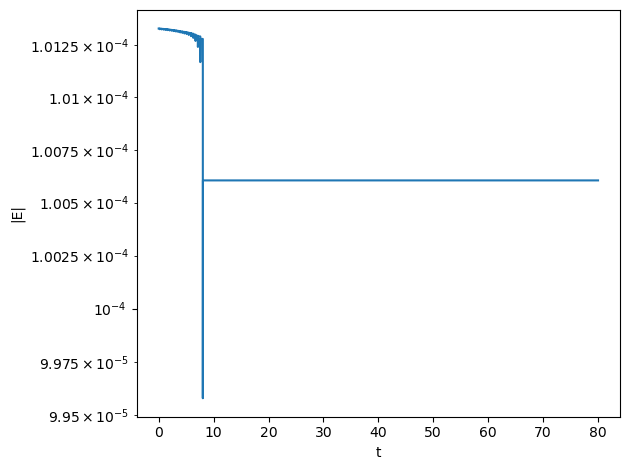

In [ ]:
# energy

fig = plt.figure()
ax = fig.add_subplot()

E = []
for n in range(tb.npts()):
    E.append(tb.energy(n))

ax.plot(t, np.abs(E))

ax.set_yscale("log")

ax.set_xlabel("t")
ax.set_ylabel("|E|")

fig.tight_layout()
fig.savefig("three_body_energy.png")

/var/folders/hf/42bt2c2j3gs468tb5xz15j800000gp/T/ipykernel_78264/388524933.py:25: RuntimeWarning: divide by zero encountered in divide
  ddr = 4*25/dv**2 #binding radius
/var/folders/hf/42bt2c2j3gs468tb5xz15j800000gp/T/ipykernel_78264/388524933.py:30: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,10)
/var/folders/hf/42bt2c2j3gs468tb5xz15j800000gp/T/ipykernel_78264/388524933.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10)


(0.005991180526621646, 10)

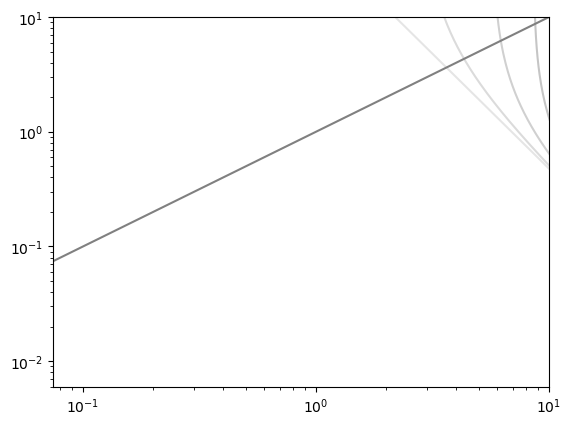

In [120]:
def vk(r,m= 4e6):
    return np.sqrt(m/r)

def rH(r,m=25,M=4e6):
    return r*(m/(3*M))**(1/3.)
   
for phi in np.radians(np.linspace(0,40,20)):
    r_m = 1537 #au
    dr = np.linspace(0,300,300)
    r_1 = r_m - dr
    v_1 = vk(r_1) 
    r_2 = r_m + dr 
    v_2 = vk(r_2)
    v_2x = -(v_2)*np.sin(phi)
    v_2y = (v_2)*np.cos(phi)
    v_cmx = v_2x
    v_cmy = (v_2y+v_1)*0.5
    v_2x -= v_cmx
    v_2y -= v_cmy
    v_1 -= v_cmy
    dv = np.sqrt((v_2x)**2+(v_2y-v_1)**2)
    x_2 = r_2*np.cos(phi)
    y_2 = r_2*np.sin(phi)
    dr2 = np.sqrt((x_2-r_1)**2 + y_2**2)
    ddr = 4*25/dv**2 #binding radius


    plt.plot(dr2/rH(r_m),ddr/rH(r_m),alpha=np.degrees(phi)/50+0.1,color='black')
plt.loglog(np.linspace(0,50,100),np.linspace(0,50,100),color='gray')
plt.xlim(0,10)
plt.ylim(0,10)